In [1]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
DATA = '../Data/out.moreno_crime_crime'
ROLE = '../Data/rel.moreno_crime_crime.person.role'
NAME = '../Data/ent.moreno_crime_crime.person.name'
SEX =  '../Data/ent.moreno_crime_crime.person.sex'

In [3]:
with open(DATA) as f:
    data = f.read().splitlines()
    
with open(ROLE) as f:
    role = f.read().splitlines()
    
with open(NAME) as f:
    name = f.read().splitlines()
    
with open(SEX) as f:
    sex = f.read().splitlines()
    
for i in range(len(data)):
    data[i] = 'p' + data[i]

In [4]:
B = nx.read_edgelist(data)
print(len(B.nodes()), len(B.edges()))

1380 1476


In [5]:
graph = np.loadtxt(DATA)
a = np.unique(graph[:,0])
b = np.unique(graph[:,1])
a = ['p' + str(int(a)) for a in a]
b = [str(int(b)) for b in b]
len(a), len(b)

(829, 551)

In [6]:
G = nx.Graph()
for j in range(len(a)):
    G.add_node(a[j], bipartite=0, data=True, name=name[j], sex=sex[j])
print(len(G.nodes()))
t = len(G.nodes())
G.add_nodes_from(b, bipartite=1, data=True)
print(len(G.nodes())-t)

829
551


In [7]:
print(len(G.nodes()))
nx.get_node_attributes(G, 'name')

1380


{'p1': 'AbelDennis',
 'p2': 'AbramsChad',
 'p3': 'AbramsDavid',
 'p4': 'AbramsDon',
 'p5': 'AbramsRichard',
 'p6': 'AdamsCurtis',
 'p7': 'AdamsMartha',
 'p8': 'AdamsReggie',
 'p9': 'AlexanderDevon',
 'p10': 'AlexanderNolan',
 'p11': 'AlexanderTrina',
 'p12': 'AlleynCamilla',
 'p13': 'AlleynCarolyn',
 'p14': 'AlleynDylan',
 'p15': 'AmadaDaron',
 'p16': 'AmanaRalph',
 'p17': 'AndersonMitch',
 'p18': 'AndersonWinston',
 'p19': 'AndrewsAlice',
 'p20': 'AndrewsHowie',
 'p21': 'AndrewsJoan',
 'p22': 'AndrewsSally',
 'p23': 'AngellDiana',
 'p24': 'ArcherThora',
 'p25': 'ArcherJr.Dylan',
 'p26': 'ArmandeBrian',
 'p27': 'ArmbrusterCassia',
 'p28': 'ArmstrongPearl',
 'p29': 'ArthurDean',
 'p30': 'AshRalph',
 'p31': 'AsherJames',
 'p32': 'AveryPhil',
 'p33': 'AveryTerry',
 'p34': 'BackusConner',
 'p35': 'BaconFrancis',
 'p36': 'BallMarvin',
 'p37': 'BallMelvin',
 'p38': 'BallLester',
 'p39': 'BarkerCatherine',
 'p40': 'BarkerMarianne',
 'p41': 'BarkerQuincy',
 'p42': 'BarretScott',
 'p43': 'Barre

In [8]:
i = 0
for edge in B.edges():
    G.add_edge(edge[0], edge[1], weight= [role[i]])
    i+=1

len(G.nodes()), len(G.edges)

(1380, 1476)

In [9]:
nx.get_edge_attributes(G, 'weight')

{('p1', '1'): ['Suspect'],
 ('p1', '2'): ['Victim'],
 ('p1', '3'): ['Victim'],
 ('p1', '4'): ['Suspect'],
 ('p2', '5'): ['Suspect'],
 ('p2', '6'): ['Suspect'],
 ('p2', '7'): ['Suspect'],
 ('p2', '8'): ['Suspect'],
 ('p2', '9'): ['Suspect'],
 ('p2', '10'): ['Witness'],
 ('p2', '11'): ['Suspect'],
 ('p2', '12'): ['Suspect'],
 ('p2', '13'): ['Suspect'],
 ('p2', '14'): ['Suspect'],
 ('p2', '15'): ['Victim'],
 ('p2', '16'): ['Suspect'],
 ('p2', '17'): ['Suspect'],
 ('p2', '18'): ['Suspect'],
 ('p2', '19'): ['Victim'],
 ('p2', '20'): ['Suspect'],
 ('p2', '21'): ['Suspect'],
 ('p2', '22'): ['Suspect'],
 ('p2', '23'): ['Suspect'],
 ('p2', '24'): ['Suspect'],
 ('p2', '25'): ['Victim'],
 ('p2', '26'): ['Victim'],
 ('p3', '27'): ['Victim'],
 ('p4', '24'): ['Suspect'],
 ('p5', '19'): ['Suspect'],
 ('p6', '28'): ['Victim'],
 ('p7', '29'): ['Witness'],
 ('p8', '30'): ['Victim'],
 ('p9', '31'): ['Suspect'],
 ('p10', '32'): ['Suspect'],
 ('p10', '33'): ['Witness'],
 ('p10', '34'): ['Victim'],
 ('p10',

In [10]:
cluster = bipartite.clustering(B)
sum(cluster.values())/len(cluster.values())

0.4274751302606178

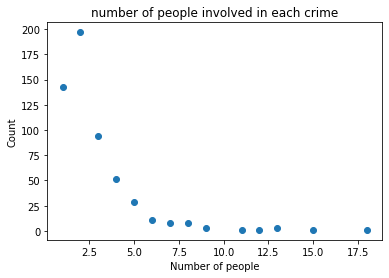

In [11]:
e_p = []
e_c = []
for k in G.nodes():
    if G.nodes[k]["bipartite"] == 0:
        e_p.append(len(G.edges(k)))
    else:
        e_c.append(len(G.edges(k)))

e_cc = Counter(e_c)
plt.scatter(e_cc.keys(), e_cc.values())
plt.title('number of people involved in each crime')
plt.xlabel('Number of people')
plt.ylabel('Count');

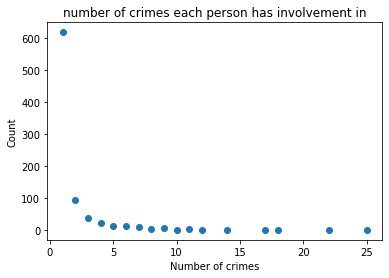

In [12]:
e_pc = Counter(e_p)
plt.scatter(e_pc.keys(), e_pc.values())
plt.title('number of crimes each person has involvement in')
plt.xlabel('Number of crimes')
plt.ylabel('Count');

In [13]:
top_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(G) - top_nodes

829


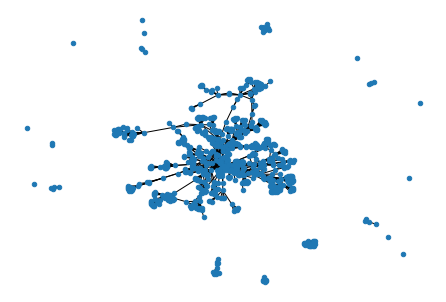

In [14]:
P = bipartite.weighted_projected_graph(G, top_nodes)
print(len(P.nodes()))
nx.draw(P, node_size=20)

551


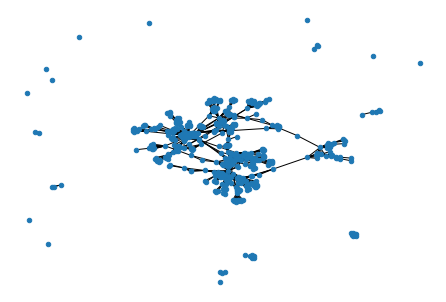

In [15]:
C = bipartite.weighted_projected_graph(G, bottom_nodes)
print(len(C.nodes))
nx.draw(C, node_size=20)

In [16]:
# components in the graph sorted in descendent order
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
# selecting the biggest component
G0 = G.subgraph(Gcc[0])
len(G0.nodes)

1263

In [17]:
top_nodes_gcc = {n for n, d in G0.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes_gcc = set(G0) - top_nodes_gcc

len(top_nodes_gcc), len(bottom_nodes_gcc)

(754, 509)

754


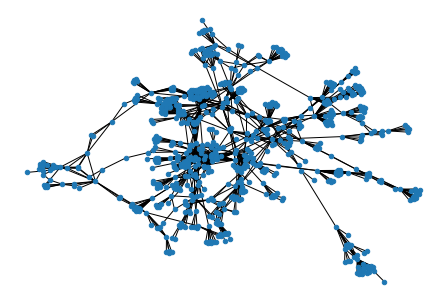

In [18]:
# plot only biggest component
P = bipartite.weighted_projected_graph(G0, top_nodes_gcc)
print(len(P.nodes()))
nx.draw(P, node_size=20)

In [19]:
node_neighbors = {n: len(set(G.neighbors(n))) for n in top_nodes_gcc}
maxnode = max(node_neighbors, key = node_neighbors.get)
print(maxnode, node_neighbors[maxnode])

node_neighbors = {n: len(set(G.neighbors(n))) for n in bottom_nodes_gcc}
maxnode = max(node_neighbors, key = node_neighbors.get)
print(maxnode, node_neighbors[maxnode])

p815 25
110 18


In [26]:
## Seperating layers

victims = [e[0] for e in nx.get_edge_attributes(G0, 'weight') if nx.get_edge_attributes(G, 'weight')[e] == ['Victim'] or  nx.get_edge_attributes(G, 'weight')[e] == ['Victim Suspect']]
suspects = [e[0] for e in nx.get_edge_attributes(G0, 'weight') if nx.get_edge_attributes(G, 'weight')[e] == ['Suspect'] or  nx.get_edge_attributes(G, 'weight')[e] == ['Victim Suspect']]
witnesses = [e[0] for e in nx.get_edge_attributes(G0, 'weight') if nx.get_edge_attributes(G, 'weight')[e] == ['Witness']]

In [27]:
print(f'Number of victims {len(victims)}, unique {len(set(victims))}')
print(f'number of suspects {len(suspects)}, unique {len(set(suspects))}')
print(f'number of witnesses {len(witnesses)}, unique {len(set(witnesses))}')
print(f'Total number {len(suspects + witnesses + victims)}, unique {len(set(suspects + witnesses + victims))}')

Number of victims 557, unique 374
number of suspects 680, unique 448
number of witnesses 179, unique 155
Total number 1416, unique 754


In [28]:
other = [e for e in G0.edges() if e[0] not in victims and e[0] not in suspects and e[0] not in witnesses]
         
print(len(other))#sanity check that all people nodes are accounted for

0


In [67]:
v = Counter(victims)
v_top = v.most_common(43) #victim at least 3 times
v_top

[('p815', 11),
 ('p220', 9),
 ('p356', 6),
 ('p404', 6),
 ('p425', 6),
 ('p474', 6),
 ('p497', 6),
 ('p715', 6),
 ('p56', 5),
 ('p88', 5),
 ('p190', 5),
 ('p549', 5),
 ('p2', 4),
 ('p10', 4),
 ('p37', 4),
 ('p62', 4),
 ('p115', 4),
 ('p155', 4),
 ('p214', 4),
 ('p291', 4),
 ('p336', 4),
 ('p413', 4),
 ('p414', 4),
 ('p514', 4),
 ('p533', 4),
 ('p592', 4),
 ('p690', 4),
 ('p696', 4),
 ('p51', 3),
 ('p221', 3),
 ('p242', 3),
 ('p277', 3),
 ('p370', 3),
 ('p384', 3),
 ('p452', 3),
 ('p515', 3),
 ('p572', 3),
 ('p642', 3),
 ('p659', 3),
 ('p729', 3),
 ('p767', 3),
 ('p797', 3),
 ('p811', 3)]

In [70]:
s = Counter(suspects)
s_top = s.most_common(44) #suspect at least 3 times
s_top

[('p2', 17),
 ('p815', 12),
 ('p425', 9),
 ('p695', 9),
 ('p514', 8),
 ('p531', 8),
 ('p220', 6),
 ('p715', 6),
 ('p56', 5),
 ('p74', 5),
 ('p108', 5),
 ('p592', 5),
 ('p696', 5),
 ('p10', 4),
 ('p37', 4),
 ('p51', 4),
 ('p67', 4),
 ('p88', 4),
 ('p115', 4),
 ('p356', 4),
 ('p474', 4),
 ('p549', 4),
 ('p577', 4),
 ('p659', 4),
 ('p690', 4),
 ('p729', 4),
 ('p106', 3),
 ('p128', 3),
 ('p159', 3),
 ('p174', 3),
 ('p303', 3),
 ('p333', 3),
 ('p336', 3),
 ('p384', 3),
 ('p396', 3),
 ('p404', 3),
 ('p410', 3),
 ('p411', 3),
 ('p536', 3),
 ('p572', 3),
 ('p584', 3),
 ('p600', 3),
 ('p663', 3),
 ('p788', 3)]

In [71]:
w = Counter(witnesses)
w.most_common(10)

[('p79', 5),
 ('p56', 4),
 ('p425', 3),
 ('p736', 3),
 ('p17', 2),
 ('p112', 2),
 ('p129', 2),
 ('p159', 2),
 ('p220', 2),
 ('p277', 2)]

In [77]:
sus = [s[0] for s in s_top]
vic = [v[0] for v in v_top]

vic_sus = [x for x in sus if x in vic]

female = []
male = []

for person in vic_sus:
    print(nx.get_node_attributes(G, 'name')[person])
    if nx.get_node_attributes(G, 'sex')[person] == '0':
        female.append(person)
    else:
        male.append(person)
        
len(female), len(male)

AbramsChad
WillisJenny
KatzLuella
McCannEddie
DicksonCarter
SteinerCatherine
BendixJerryLee
PetersTrish
SmithVictoria
AlexanderNolan
BallMelvin
BeckerToby
BowersCarl
BurnleyAaron
HemphillBud
LockePamela
MunsonKaty
SamuelLyle
SlatteryMaurice
SummersLana
HallLiz
HoweRuth
JeffersonArnold
ParkerByron


(10, 14)